In [1]:
FOLDER_TEST = "C:/JupyterLab/github_repos/NLP_project/Processamento_Imagem/Images_data/test_set_reduced/*"
FOLDER_TRAIN = "C:/JupyterLab/github_repos/NLP_project/Processamento_Imagem/Images_data/training_set_reduced/*"

<Figure size 1000x800 with 0 Axes>

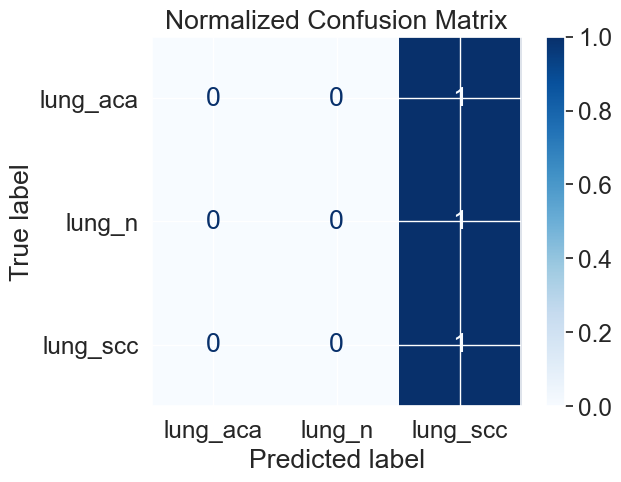

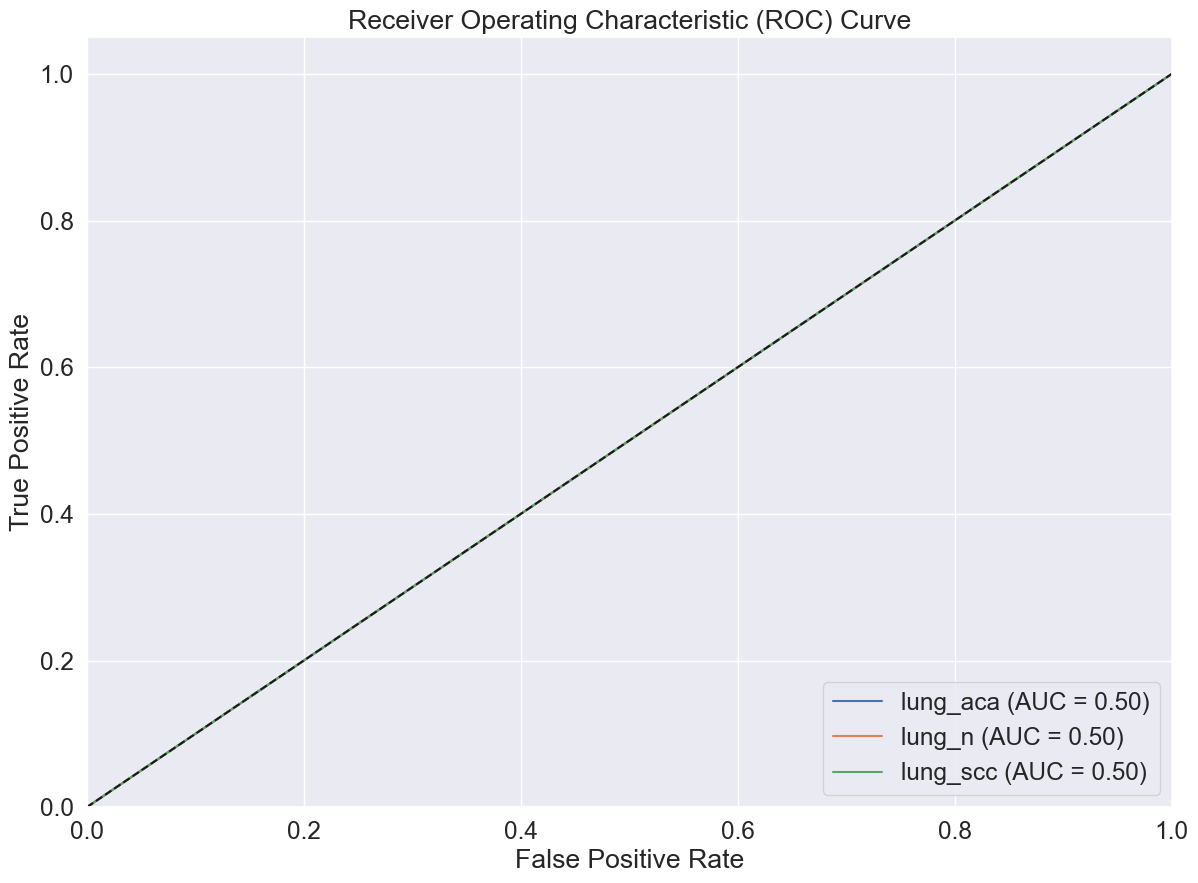

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import os
import seaborn as sns
import pandas as pd
from skimage.filters import sobel
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
from sklearn.model_selection import cross_val_score, StratifiedKFold
from joblib import Parallel, delayed
from concurrent.futures import ThreadPoolExecutor
import logging
import time

# Setup logging
logging.basicConfig(filename='hpc_log.log', level=logging.INFO)
logger = logging.getLogger()

# Function to log the duration of a function call
def log_time(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time
        logger.info(f"{func.__name__} took {elapsed_time:.2f} seconds to run.")
        return result
    return wrapper

# Resize images to
SIZE = 128

@log_time
def load_image(img_path, size=SIZE):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (size, size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

@log_time
def load_images_from_directory(directory_path, size=SIZE):
    images = []
    labels = []
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.endswith('.jpeg'):
                label = os.path.basename(root)
                img_path = os.path.join(root, file)
                img = load_image(img_path, size)
                images.append(img)
                labels.append(label)
    return images, labels

@log_time
def process_images(image_paths, size=SIZE):
    results = Parallel(n_jobs=-1)(delayed(load_images_from_directory)(path, size) for path in image_paths)
    images = [img for result in results for img in result[0]]
    labels = [label for result in results for label in result[1]]
    return np.array(images), np.array(labels)

# Load training images
train_paths = glob.glob(FOLDER_TRAIN)
train_images, train_labels = process_images(train_paths)
logger.info(f"Loaded {len(train_images)} training images.")

# Load test images
test_paths = glob.glob(FOLDER_TEST)
test_images, test_labels = process_images(test_paths)
logger.info(f"Loaded {len(test_images)} test images.")

# Encode labels
le = preprocessing.LabelEncoder()
train_labels_encoded = le.fit_transform(train_labels)
test_labels_encoded = le.transform(test_labels)

# Normalize pixel values
x_train, x_test = train_images / 255.0, test_images / 255.0

@log_time
def extract_features(image):
    df = pd.DataFrame()
    img = image

    pixel_values = img.reshape(-1)
    df['Pixel_Value'] = pixel_values

    num = 1
    kernels = []
    for theta in range(2):
        theta = theta / 4. * np.pi
        for sigma in (1, 3):
            lamda = np.pi / 4
            gamma = 0.5
            ksize = 9
            kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)
            kernels.append(kernel)
            fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
            filtered_img = fimg.reshape(-1)
            df[f'Gabor{num}'] = filtered_img
            num += 1

    edge_sobel = sobel(img).reshape(-1)
    df['Sobel'] = edge_sobel

    return df

@log_time
def feature_extractor(dataset):
    with ThreadPoolExecutor() as executor:
        features = list(executor.map(extract_features, dataset))
    return pd.concat(features, ignore_index=True)

# Extract features
image_features = feature_extractor(x_train)
test_features = feature_extractor(x_test)

# Reshape for Random Forest
X_for_RF = image_features.to_numpy().reshape(x_train.shape[0], -1)
test_for_RF = test_features.to_numpy().reshape(x_test.shape[0], -1)

# Define Random Forest model
RF_model = RandomForestClassifier(n_estimators=124, max_depth=10, min_samples_split=73, min_samples_leaf=23, random_state=42)

# Save hyperparameters to file
with open('ml_hyperparameters.txt', 'w') as f:
    f.write(f"n_estimators: {RF_model.n_estimators}\n")
    f.write(f"max_depth: {RF_model.max_depth}\n")
    f.write(f"min_samples_split: {RF_model.min_samples_split}\n")
    f.write(f"min_samples_leaf: {RF_model.min_samples_leaf}\n")
    f.write(f"random_state: {RF_model.random_state}\n")

# Perform cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(RF_model, X_for_RF, train_labels_encoded, cv=cv, scoring='accuracy')
logger.info(f"Cross-validation accuracy scores: {cv_scores}")
logger.info(f"Mean cross-validation accuracy: {cv_scores.mean()}")

# Train Random Forest model
RF_model.fit(X_for_RF, train_labels_encoded)

# Predict on test data
test_prediction = RF_model.predict(test_for_RF)
test_prediction_proba = RF_model.predict_proba(test_for_RF)

# Inverse transform to original labels
test_prediction = le.inverse_transform(test_prediction)

# Print accuracy
accuracy = accuracy_score(test_labels, test_prediction)
logger.info(f"Test Accuracy = {accuracy}")

# Print confusion matrix
cm = confusion_matrix(test_labels, test_prediction)
cm_normalized = cm.astype(np.float64) / cm.sum(axis=1)[:, np.newaxis]

# Save confusion matrix as image
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.6)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Normalized Confusion Matrix")
plt.savefig("confusion_matrix.png")
logger.info("Confusion matrix saved as 'confusion_matrix.png'.")

# Save confusion matrix to .txt file
with open('confusion_matrix.txt', 'w') as f:
    f.write('Confusion Matrix:\n')
    f.write(np.array2string(cm, separator=', '))
    f.write('\n\nNormalized Confusion Matrix:\n')
    f.write(np.array2string(cm_normalized, separator=', '))
logger.info("Confusion matrix saved as 'confusion_matrix.txt'.")

# Plot AUC ROC Curve
plt.figure(figsize=(14, 10))
roc_data = []
for i, class_label in enumerate(le.classes_):
    fpr, tpr, _ = roc_curve(test_labels_encoded == i, test_prediction_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_label} (AUC = {roc_auc:.2f})')
    roc_data.append((class_label, fpr, tpr, roc_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig("roc_curve.png")
logger.info("ROC curve saved as 'roc_curve.png'.")

# Save ROC AUC data to .txt file
with open('roc_auc_data.txt', 'w') as f:
    for class_label, fpr, tpr, roc_auc in roc_data:
        f.write(f"Class: {class_label}\n")
        f.write(f"AUC: {roc_auc:.2f}\n")
        f.write("FPR: " + ", ".join(map(str, fpr)) + "\n")
        f.write("TPR: " + ", ".join(map(str, tpr)) + "\n")
        f.write("\n")
logger.info("ROC AUC data saved as 'roc_auc_data.txt'.")

# End of script
logger.info("Script execution completed.")